In [19]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60

df = df / 1000
df

,АЗС №35400 Кичменгский Городок,АЗС №35401 Великий Устюг-1,АЗС №35402 Великий Устюг-2,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35406 Журавлево,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,99.2272,101.8513,139.2135,154.2522,777.2635,102.4328,520.5020,517.8863,266.7014,...,610.3886,610.3028,607.3283,609.0579,611.0852,611.0605,604.2684,605.7555,502.9826,477.9325
1,99.0684,0.0000,4.9465,134.5201,149.5589,748.0318,5.5280,491.2703,488.6546,241.7276,...,581.1570,581.0711,578.0967,579.8263,581.8535,581.8288,575.0368,576.5238,473.7510,448.7008
2,101.8148,5.0688,0.0000,137.2665,152.3053,750.7781,3.0302,494.0166,491.4010,244.4739,...,583.9033,583.8174,580.8430,582.5726,584.5999,584.5752,577.7831,579.2702,476.4973,451.4472
3,139.2135,134.6791,137.3031,0.0000,15.0961,613.5690,137.8846,356.8075,354.1918,107.2648,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
4,154.2522,149.7178,152.3419,15.0961,0.0000,613.8947,152.9234,357.1332,354.5176,107.5905,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,611.7861,582.6174,585.2414,447.9957,448.3214,191.2351,585.8229,181.8523,179.2367,345.2112,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
60,605.7962,576.6275,579.2515,442.0057,442.3315,185.0682,579.8330,175.8624,173.2467,339.2213,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
61,607.1467,577.9779,580.6020,443.3562,443.6820,186.4186,581.1835,177.2129,174.5972,340.5717,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
62,504.6641,475.4954,478.1194,340.8736,341.1994,274.3706,478.7009,74.7303,72.1146,238.0892,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [20]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35412 Вытегра,АЗС №35413 Липник,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,613.5690,356.8075,354.1918,107.2648,619.0077,618.5201,629.3182,472.6696,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,613.8947,357.1332,354.5176,107.5905,619.3335,618.8458,629.6440,472.9954,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
2,615.1980,615.5238,0.0000,349.0547,346.4390,512.4135,142.9597,142.4720,165.8965,193.2966,...,187.4480,187.3622,184.7850,188.3816,183.6881,191.1772,185.1426,186.6296,274.4141,309.3918
3,356.1259,356.4516,349.7479,0.0000,3.7018,253.3414,355.1867,354.6990,373.5276,216.8790,...,182.8731,182.7873,179.8128,181.5424,183.5697,183.5450,176.7529,178.2400,75.4671,45.6714
4,353.5507,353.8764,347.1727,3.7422,0.0000,250.7662,352.6115,352.1238,370.9524,214.3038,...,180.2979,180.2120,177.2376,178.9672,180.9945,180.9698,174.1777,175.6648,72.8919,43.0962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,447.9957,448.3214,191.2351,181.8523,179.2367,345.2112,196.6738,196.1861,332.9386,176.2900,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,442.0057,442.3315,185.0682,175.8624,173.2467,339.2213,190.5069,190.0192,326.9487,170.3001,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,443.3562,443.6820,186.4186,177.2129,174.5972,340.5717,191.8574,191.3697,328.2991,171.6506,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,340.8736,341.1994,274.3706,74.7303,72.1146,238.0892,279.8093,279.3216,346.5072,189.8586,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [21]:
from numpy.random import default_rng

#shrink array
df = df.iloc[35:56,35:56]
#rng = default_rng()
# idx = rng.choice(len(df.values[0])-1, size=len(df.values[0]) - 1 - 10, replace=False)
# df = df.drop(df.index[idx])
# df = df.drop(df.columns[idx], axis=1)
#df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

21


,АЗС №35443 Маршала Конева-1,АЗС №35444 Маршала Конева-2,АЗС №35445 Чернышевского-1,АЗС №35446 Чернышевского-2,АЗС №35447 Ленинградская,АЗС №35448 Водников,АЗС №35449 Нелазское,АЗС №35450 Кирилловское шоссе-1,АЗС №35451 Кирилловское шоссе-2,АЗС №35452 Металлургов,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
35,0.0000,0.8744,9.3228,8.3805,6.4668,6.7642,142.6317,135.8030,135.0745,139.8995,...,141.2132,141.1273,138.1529,139.8825,141.9098,141.8851,135.0930,136.5801,33.8072,4.3326
36,0.9694,0.0000,9.9495,9.0072,5.7395,7.3909,141.9043,135.0757,134.3472,139.1721,...,140.4858,140.4000,137.4255,139.1551,141.1824,141.1577,134.3656,135.8527,33.0798,4.9593
37,9.2279,9.9921,0.0000,1.1937,8.5790,6.1599,144.3582,137.5296,136.8011,141.6260,...,142.9397,142.8539,139.8794,141.6090,143.6363,143.6116,136.8195,138.3066,35.5337,8.7439
38,8.7463,9.5105,0.9112,0.0000,8.0974,5.6783,143.8767,137.0480,136.3195,141.1445,...,142.4582,142.3723,139.3979,141.1275,143.1547,143.1300,136.3380,137.8250,35.0522,8.2623
39,6.4840,5.5455,9.1759,8.2335,0.0000,8.2110,136.9298,130.1011,129.3726,134.1976,...,135.5113,135.4254,132.4510,134.1806,136.2078,136.1831,129.3911,130.8781,28.1053,9.0576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,141.0550,140.1165,142.3077,141.3654,135.3616,141.3429,25.7787,7.4471,6.7238,8.8138,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,135.0651,134.1266,136.3178,135.3754,129.3717,135.3530,19.6118,1.4624,0.7339,5.5588,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,136.4156,135.4771,137.6683,136.7259,130.7221,136.7034,20.9623,2.8129,2.0844,6.9093,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,33.9330,32.9945,35.1857,34.2433,28.2396,34.2209,108.9142,102.0856,101.3571,106.1820,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


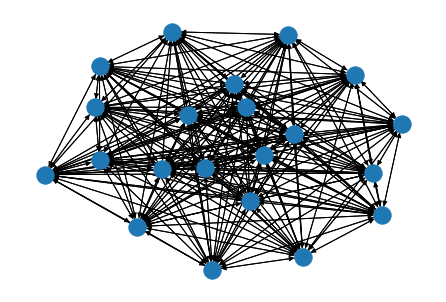

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G)
plt.show()

In [23]:
#custom gym environment for our problem
m = 5
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [24]:
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 1
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config["env_config"] = {}
#config['learning_rate'] = 0.0001

In [25]:
ray.shutdown()
ray.init()

2022-05-28 13:24:45,978	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.72', 'raylet_ip_address': '192.168.1.72', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-28_13-24-43_530424_549778/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-28_13-24-43_530424_549778/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-05-28_13-24-43_530424_549778', 'metrics_export_port': 61420, 'gcs_address': '192.168.1.72:58411', 'address': '192.168.1.72:58411', 'node_id': '2d5475bec22bbf5414f882a636a31b052c83466bacda14baaabd69a1'})

In [26]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [27]:
import datetime
start = datetime.datetime.now()
print(start)

for i in range(1501):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
duration.total_seconds() / 3600

2022-05-28 13:24:52.882774
i:  0
mean episode length: 81.20408163265306
max episode reward: -119593.13309999999
mean episode reward: -378566.25259795913
min episode reward: -881846.4241000001
total episodes: 49
i:  10
mean episode length: 85.05
max episode reward: -101341.1447
mean episode reward: -401633.425548
min episode reward: -1103792.3630000001
total episodes: 539
i:  20
mean episode length: 91.17
max episode reward: -29860.25709999999
mean episode reward: -438335.58654300007
min episode reward: -5555665.4251
total episodes: 993
i:  30
mean episode length: 69.57
max episode reward: -59261.344600000004
mean episode reward: -308644.570191
min episode reward: -3047696.554
total episodes: 1544
i:  40
mean episode length: 48.97
max episode reward: -41326.02070000001
mean episode reward: -185171.225072
min episode reward: -677533.6368
total episodes: 2258
i:  50
mean episode length: 34.35042735042735
max episode reward: -23585.592699999997
mean episode reward: -97535.97603418803
min e

i:  470
mean episode length: 1181.12
max episode reward: -6585.5628
mean episode reward: -6974365.576055
min episode reward: -680977017.8917
total episodes: 59985
i:  480
mean episode length: 1181.12
max episode reward: -6585.5628
mean episode reward: -6974365.576055
min episode reward: -680977017.8917
total episodes: 59985
i:  490
mean episode length: 1181.12
max episode reward: -6585.5628
mean episode reward: -6974365.576055
min episode reward: -680977017.8917
total episodes: 59985
i:  500
mean episode length: 1181.12
max episode reward: -6585.5628
mean episode reward: -6974365.576055
min episode reward: -680977017.8917
total episodes: 59985
i:  510
mean episode length: 1181.12
max episode reward: -6585.5628
mean episode reward: -6974365.576055
min episode reward: -680977017.8917
total episodes: 59985
i:  520
mean episode length: 6822.07
max episode reward: -6585.5628
mean episode reward: -40820111.677286
min episode reward: -3385205564.0236
total episodes: 59986
i:  530
mean episode

i:  970
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episodes: 59987
i:  980
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episodes: 59987
i:  990
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episodes: 59987
i:  1000
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episodes: 59987
i:  1010
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episodes: 59987
i:  1020
mean episode length: 17617.8
max episode reward: -6585.5628
mean episode reward: -105594513.29743299
min episode reward: -6477447081.3144
total episo

i:  1460
mean episode length: 39980.6
max episode reward: -6585.5628
mean episode reward: -239771391.38150802
min episode reward: -6477447081.3144
total episodes: 59992
i:  1470
mean episode length: 39980.6
max episode reward: -6585.5628
mean episode reward: -239771391.38150802
min episode reward: -6477447081.3144
total episodes: 59992
i:  1480
mean episode length: 39980.6
max episode reward: -6585.5628
mean episode reward: -239771391.38150802
min episode reward: -6477447081.3144
total episodes: 59992
i:  1490
mean episode length: 39980.6
max episode reward: -6585.5628
mean episode reward: -239771391.38150802
min episode reward: -6477447081.3144
total episodes: 59992
i:  1500
mean episode length: 39980.6
max episode reward: -6585.5628
mean episode reward: -239771391.38150802
min episode reward: -6477447081.3144
total episodes: 59992
2022-05-29 03:48:58.359397


14.401521284166668

In [37]:
for i in range(501):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
duration.total_seconds() / 3600

KeyboardInterrupt: 

In [45]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.registry import register_env
logpath = "/home/basilshim/ray_results"
analysis = tune.Analysis(logpath)

AttributeError: Can't get attribute 'KLCoeffMixin' on <module 'ray.rllib.agents.ppo.ppo_torch_policy' from '/home/basilshim/anaconda3/envs/rl_gpu/lib/python3.8/site-packages/ray/rllib/agents/ppo/ppo_torch_policy.py'>

In [36]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

action: [ 4 19]; reward: 0
action: [ 4 19]; reward: -2035.4634
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action:

action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: 

action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: 

action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: [ 4 19]; reward: -6000
action: 

In [29]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

Truck #4: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1

In [30]:
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler
# from ray.tune.registry import register_env

# def env_creator(env_config):
#     return TransportScape(env_config)  

# register_env("TransportScape", env_creator)

In [31]:
# tuner_config = {
#     "env": "TransportScape",
#     "num_gpus": 0,
#     "num_workers": 1,
# #     "num_cpus_per_worker": 8,
#     "framework": "torch",
#     "lr" :         tune.grid_search([0.00001, 0.0001, 0.001]),
#     "clip_param": tune.grid_search([0.1,  0.2,  0.3]),
#     "kl_coeff":   tune.grid_search([0.0,  0.3,  0.7, 1.0]),
#     "entropy_coeff": tune.grid_search([0.01, 0.1]),
#     #"m" : tune.grid_search([2, 4, 6])
# }

# config.update(tuner_config)

In [32]:
# import datetime
# start = datetime.datetime.now()
# print(start)
# tuner = tune.run(
#     "PPO",
#     config=config,
#     metric="episode_reward_mean",
#     mode="max",
#     #stop={'episodes_total': 20000},
#     stop={"training_iteration": 50},
#     checkpoint_at_end=True,
#     local_dir="/home/basilshim/ray_results/PPO_Tune_20"
# )
# finish = datetime.datetime.now()
# print(finish)
# duration = finish - start
# duration.total_seconds() / 3600

In [33]:
# print(tuner.best_checkpoint)

In [34]:
# state = env.reset()
# g = 0
# done = False
# reward = 0
# actions = []
# i = 0
# while not done:
#     action = agent.compute_action(state, explore = False)
#     actions.append(action)
#     print("action: {:}; reward: {:}".format(action, reward))
#     state, reward, done, info = env.step(action)
#     g += reward
#     i += 1
#     if i == 1000:
#         break
# print("Final state:")
# print("Assignment:", state['assignment'])
# print("Trucks used:", state['truck usage'])
# print("Time left", state['time left'])
# print(g) 

In [35]:
%load_ext tensorboard
%tensorboard --logdir="/home/basilshim/ray_results/PPOTrainer_TransportScape_2022-05-10_20-04-42jy8w763s"